In [0]:
# # !pip install PyDrive
# https://drive.google.com/open?id=1YnvVHkVoD8lTWsq-WfK5MtMo_z8wIqVa: google drive link of all the required files
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

inp = {
    
# find the file to be used and click on get shareable link. copy all the text after open?
    # "1NvTyhUsrFbL91E10EPm38IjoCg6E2c6q" : "Cyclone_Wildfire_Flood_Earthquake_Database.zip"
    # "1EOQy59pW3ZnwBOc_MfpgA97HF632Vxut" : "clr_callback.py",
    # "1NeyxaL6AaQloh11_90udLXAD35P0x2Np" : "learningratefinder.py",
    # "1bcK2H_HiyxX8V7Q8B-yX2P4Uzt9dr_OF" : "Terrific Natural Disasters Compilation.mp4"
}
#  For files only, not for folders

for (k,v) in inp.items():
  print(k,v[:-4])

  download = drive.CreateFile({'id': k})
  download.GetContentFile(v)

# for (k,v) in inp.items():
#   if ".zip" in v:
#     target = v[:-4]
    # !unzip -q $v 
# # # # !rm -r Cyclone_Wildfire_Flood_Earthquake_Database/
OutputFolder = "/content/output/"
ProjectName = "NaturalDisasterClassification"
DriveOutputFolder = "drive/My\ Drive/Colab\ Notebooks/DLProjects/" + ProjectName +"/output/"


In [0]:
DATASET_PATH = "Cyclone_Wildfire_Flood_Earthquake_Database"
CLASSES = ["Cyclone", "Wildfire", "Flood", "Earthquake"]
TRAIN_SPLIT = 0.75
VAL_SPLIT = 0.1
TEST_SPLIT = 0.25
MIN_LR = 1e-6
MAX_LR = 1e-4
BATCH_SIZE = 32
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_OF_EPOCH = 48

MODEL_PATH = "output/natural_disaster.model"
LRFIND_PLOT_PATH = "output/lrfind_plot.png"
TRAINING_PLOT_PATH = "output/training_plot.png"
CLR_PLOT_PATH = "output/clr_plot.png"

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from learningratefinder import LearningRateFinder
from clr_callback import CyclicLR
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import sys
import os

In [0]:
# Loading images
imagePaths = list(paths.list_images(DATASET_PATH))
data = []
labels = []
# print(imagePaths[0].split(os.path.sep)[-2])

In [26]:
for (i,imagePath) in enumerate(imagePaths):
  if i % 1000 == 0:
    print("processed a total of {} images".format(i))
  label = imagePath.split(os.path.sep)[-2]
  
  image = cv2.imread(imagePath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))

  data.append(image)
  labels.append(label)

processed a total of 0 images
processed a total of 1000 images
processed a total of 2000 images
processed a total of 3000 images
processed a total of 4000 images


In [27]:
print(np.unique(labels))

['Cyclone' 'Earthquake' 'Flood' 'Wildfire']


In [0]:
# processing data
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [29]:
print(np.unique(labels))

['Cyclone' 'Earthquake' 'Flood' 'Wildfire']


In [0]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [32]:
print(labels[0])

[0 0 0 1]


In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = TEST_SPLIT, random_state = 42)

In [0]:
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY, test_size = VAL_SPLIT, random_state=84)

In [0]:
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [0]:
# loading the vgg16 model, pretrained on imagenet, without the top layer
baseModel = VGG16(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))

In [0]:
# creating the head layer of the model
headModel = baseModel.output
headModel = Flatten(name="flatter")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)

In [0]:
# creating the model
model = Model(inputs=baseModel.input, outputs=headModel)

In [0]:
for layer in baseModel.layers:
  layer.trainable = False

In [0]:
# compiling the model
opt = SGD(lr=MIN_LR, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics = ["accuracy"])

[INFO] finding learning rate...
Epoch 1/20
94/94 [==============================] - 42s 446ms/step - loss: 17.7563 - accuracy: 0.2520
Epoch 2/20
94/94 [==============================] - 41s 436ms/step - loss: 17.8554 - accuracy: 0.2403
Epoch 3/20
94/94 [==============================] - 41s 434ms/step - loss: 18.0683 - accuracy: 0.2440
Epoch 4/20
94/94 [==============================] - 41s 435ms/step - loss: 17.6475 - accuracy: 0.2463
Epoch 5/20
94/94 [==============================] - 41s 436ms/step - loss: 17.6790 - accuracy: 0.2477
Epoch 6/20
94/94 [==============================] - 41s 436ms/step - loss: 16.8465 - accuracy: 0.2537
Epoch 7/20
94/94 [==============================] - 41s 439ms/step - loss: 13.9654 - accuracy: 0.3240
Epoch 8/20
94/94 [==============================] - 41s 434ms/step - loss: 11.6402 - accuracy: 0.3768
Epoch 9/20
94/94 [==============================] - 41s 435ms/step - loss: 6.9927 - accuracy: 0.5258
Epoch 10/20
94/94 [==============================] 

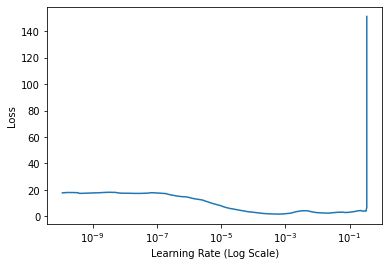

In [46]:
# check to see if we are attempting to find an optimal learning rate
# before training for the full number of epochs
find_lr = 1
if find_lr > 0:
	# initialize the learning rate finder and then train with learning
	# rates ranging from 1e-10 to 1e+1
	print("[INFO] finding learning rate...")
	lrf = LearningRateFinder(model)
	lrf.find(
		aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
		1e-10, 1e+1,
		stepsPerEpoch=np.ceil((trainX.shape[0] / float(BATCH_SIZE))),
		epochs=20,
		batchSize=BATCH_SIZE)
 
	# plot the loss for the various learning rates and save the
	# resulting plot to disk
	lrf.plot_loss()
	plt.savefig(LRFIND_PLOT_PATH)
 
	# gracefully exit the script so we can adjust our learning rates
	# in the config and then train the network for our full set of
	# epochs
	print("[INFO] learning rate finder complete")
	print("[INFO] examine plot and adjust learning rates before training")

In [0]:
# initialise the cyclir lr 
stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
    mode = CLR_METHOD,
    base_lr = MIN_LR,
    max_lr = MAX_LR,
    step_size = stepSize
)

In [50]:
# train the network
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size = BATCH_SIZE),
    validation_data = (valX, valY),
    steps_per_epoch = trainX.shape[0] // BATCH_SIZE,
    epochs = NUM_OF_EPOCH,
    callbacks = [clr],
    verbose = 1
)

Epoch 1/48
93/93 [==============================] - 45s 481ms/step - loss: 10.5499 - accuracy: 0.4097 - val_loss: 1.7874 - val_accuracy: 0.7718
Epoch 2/48
93/93 [==============================] - 43s 460ms/step - loss: 3.6150 - accuracy: 0.6905 - val_loss: 1.0052 - val_accuracy: 0.8769
Epoch 3/48
93/93 [==============================] - 43s 464ms/step - loss: 2.1168 - accuracy: 0.7804 - val_loss: 1.0090 - val_accuracy: 0.8919
Epoch 4/48
93/93 [==============================] - 44s 470ms/step - loss: 1.5539 - accuracy: 0.8214 - val_loss: 0.7218 - val_accuracy: 0.9069
Epoch 5/48
93/93 [==============================] - 43s 467ms/step - loss: 1.1762 - accuracy: 0.8244 - val_loss: 0.6258 - val_accuracy: 0.9159
Epoch 6/48
93/93 [==============================] - 43s 463ms/step - loss: 0.9593 - accuracy: 0.8349 - val_loss: 0.5313 - val_accuracy: 0.9129
Epoch 7/48
93/93 [==============================] - 43s 462ms/step - loss: 0.7904 - accuracy: 0.8403 - val_loss: 0.4534 - val_accuracy: 0.915

In [52]:
# evaluating the network
predictions = model.predict(testX, batch_size = BATCH_SIZE)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names = CLASSES))

              precision    recall  f1-score   support

     Cyclone       0.96      0.97      0.97       205
    Wildfire       0.97      0.94      0.96       353
       Flood       0.89      0.94      0.92       267
  Earthquake       0.97      0.94      0.96       282

    accuracy                           0.95      1107
   macro avg       0.95      0.95      0.95      1107
weighted avg       0.95      0.95      0.95      1107



In [53]:
# saving the model
model.save(MODEL_PATH)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: output/natural_disaster.model/assets


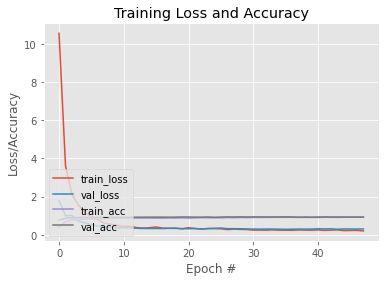

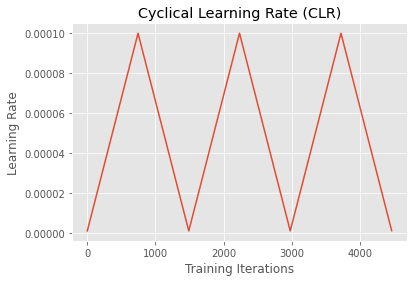

In [57]:
# construct a plot that plots and saves the training history
N = np.arange(0, NUM_OF_EPOCH)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_PATH)
# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.savefig(CLR_PLOT_PATH)

In [0]:
# NOT WORKING

# import the necessary packages
from tensorflow.keras.models import load_model
from collections import deque
import numpy as np
import argparse
import cv2

# load the trained model from disk
print("[INFO] loading model and label binarizer...")
model = load_model(MODEL_PATH)

# initialize the predictions queue
Q = deque(maxlen=0)

# initialize the video stream, pointer to output video file, and
# frame dimensions
print("[INFO] processing video...")
vs = cv2.VideoCapture("Terrific Natural Disasters Compilation.mp4")
print(vs)
writer = None
(W, H) = (None, None)
 
# loop over frames from the video file stream
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()
 
	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break
	print("grabbed")
	# if the frame dimensions are empty, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]

	# clone the output frame, then convert it from BGR to RGB
	# ordering and resize the frame to a fixed 224x224
	output = frame.copy()
	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	frame = cv2.resize(frame, (224, 224))
	frame = frame.astype("float32")
	
	# make predictions on the frame and then update the predictions
	# queue
	preds = model.predict(np.expand_dims(frame, axis=0))[0]
	Q.append(preds)

	# perform prediction averaging over the current history of
	# previous predictions
	results = np.array(Q).mean(axis=0)
	i = np.argmax(results)
	label = CLASSES[i]

	# draw the activity on the output frame
	text = "activity: {}".format(label)
	cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
		1.25, (0, 255, 0), 5)
 
	# check if the video writer is None
	if writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter("output/natural_disasters.avi", fourcc, 30,
			(W, H), True)
 
	# write the output frame to disk
	writer.write(output)
 
	# check to see if we should display the output frame to our
	# screen

	display = 0
	if display > 0:
		# show the output image
		cv2.imshow("Output", output)
		key = cv2.waitKey(1) & 0xFF
	 
		# if the `q` key was pressed, break from the loop
		if key == ord("q"):
			break
 
# release the file pointers
print("[INFO] cleaning up...")
# writer.release()
vs.release()

In [66]:
# DOES NOT WORK
# !zip output.zip output/
# # Drivebase =  '/content/drive/My Drive/Colab Notebooks/DLProjects/TrafficSignclassification/Code/'
# upload = drive.CreateFile({'title': 'output.zip'})
# upload.SetContentFile('output.zip')
# upload.Upload()

updating: output/ (stored 0%)


In [84]:
from google.colab import drive
drive.mount('/content/drive')
!ls drive/My\ Drive/Colab\ Notebooks/DLProjects/NaturalDisasterClassification
!ls /content/output
!cp -r $OutputFolder $DriveOutputFolder

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 clr_callback.py
 Cyclone_Wildfire_Flood_Earthquake_Database.zip
 learningratefinder.py
 NaturalDisasterClassification.ipynb
 output
'Terrific Natural Disasters Compilation.mp4'
clr_plot.png	 natural_disaster.model  training_plot.png
lrfind_plot.png  natural_disasters.avi
